In [59]:
import torchaudio
import torch
import matplotlib.pyplot as plt
import os

In [25]:
def load_audio(audio_file):
    waveform, sample_rate = torchaudio.load(audio_file)
    return waveform, sample_rate

In [34]:
# org_waveform, org_sample_rate = torchaudio.load("./DATASETS/Fake_unprocessed/LJ001-0001_generated_ljspeech_hifiGAN.wav")

In [61]:
def detect_audio_quality(waveform, sample_rate):
    audio_length = waveform.size(1) / sample_rate
#     print(f"Audio length: {audio_length:.2f} seconds")
#     print(f"Detected sampling rate: {sample_rate} Hz")

    amplitude_threshold = 0.01
    silenced_waveform = waveform[:, waveform.abs().max(dim=0).values > amplitude_threshold]

    silence_lengths = get_silence_lengths(silenced_waveform, sample_rate)
#     print(f"Detected speech segments: {silenced_waveform.size(1)}")
#     print(f"Length of silences: {silence_lengths}")

def get_silence_lengths(waveform, sample_rate):
    silences = torchaudio.transforms.Vad(sample_rate=sample_rate)(waveform)
    silence_lengths = silences.sum(dim=1).float() / sample_rate  # Calculate the length of silences in seconds
    return silence_lengths

In [46]:
def remove_silences(waveform, amplitude_threshold):
    return waveform[:, waveform.abs().max(dim=0).values > amplitude_threshold]

In [47]:
def resample_audio(waveform, sample_rate):
    return torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

In [48]:
# def normalize_audio(waveform):
#     return torchaudio.transforms.Vol(1)(waveform)

In [49]:
def normalize_audio(waveform, target_duration=2, sample_rate=16000):
    current_duration = waveform.size(1) / sample_rate  # Calculate the current duration in seconds
    target_samples = int(target_duration * sample_rate)  # Calculate the target samples for the desired duration

    if waveform.size(1) < target_samples:
        # Pad audio if it's shorter than the target duration
        pad = torch.zeros(1, target_samples - waveform.size(1))
        normalized_waveform = torch.cat([waveform, pad], dim=1)
    else:
        # Trim audio if it's longer than the target duration
        normalized_waveform = waveform[:, :target_samples]

    return normalized_waveform

In [50]:
def trim_audio_length(waveform, desired_length):
    target_samples = int(desired_length * 16000)
    if waveform.size(1) > target_samples:
        return waveform[:, :target_samples]
    return waveform

In [51]:
def preprocess_audio(waveform, sample_rate, desired_length=4):
    amplitude_threshold = waveform.abs().max() * 0.02
    silenced_waveform = remove_silences(waveform, amplitude_threshold)
    resampled_audio = resample_audio(silenced_waveform, sample_rate)
    normalized_audio = normalize_audio(resampled_audio)
    processed_waveform = trim_audio_length(normalized_audio, desired_length)

    return processed_waveform

In [52]:
def visualize_audio(waveform):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.t().numpy())
    plt.title('Processed Audio Waveform')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

In [53]:
def save_processed_audio(waveform, file_name, sample_rate=16000):
    torchaudio.save(file_name, waveform, sample_rate)

Audio length: 9.65 seconds
Detected sampling rate: 22050 Hz
Detected speech segments: 138096
Length of silences: tensor([0.0005])


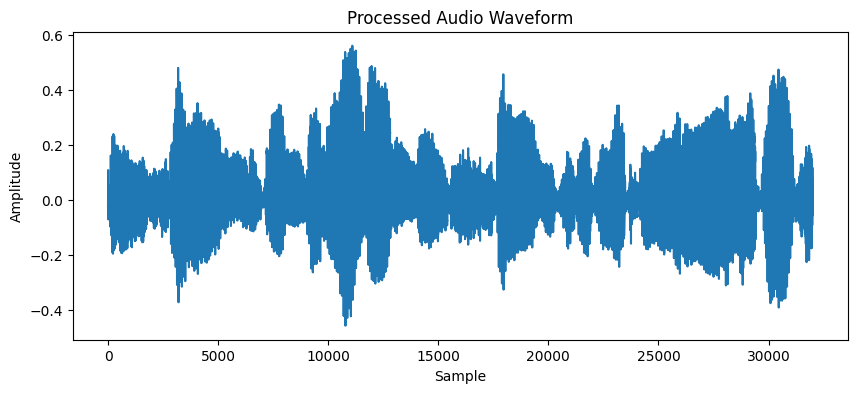

In [54]:
if __name__ == "__main__":
    audio_file = "./DATASETS/WaveFake/generated_audio/ljspeech_hifiGAN/LJ001-0001_generated.wav"

    waveform, sample_rate = load_audio(audio_file)
    detect_audio_quality(waveform, sample_rate)
    processed_waveform = preprocess_audio(waveform, sample_rate)
    visualize_audio(processed_waveform)
    output_file = "+latest_processed_audio.wav"
    save_processed_audio(processed_waveform, output_file)

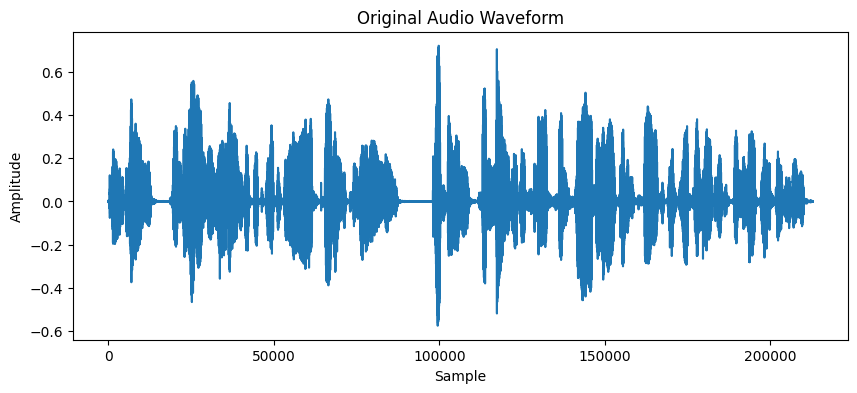

In [35]:
plt.figure(figsize=(10, 4))
plt.plot(org_waveform.t().numpy())
plt.title('Original Audio Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [40]:
detect_audio_quality(processed_waveform, sample_rate)

Audio length: 1.45 seconds
Detected sampling rate: 22050 Hz
Detected speech segments: 30374
Length of silences: tensor([0.0002])


In [56]:
def process_directory(directory_path, output_path):
    bonafide_dir = os.path.join(directory_path, 'Bonafide')
    fake_dir = os.path.join(directory_path, 'Fake')
    output_bonafide_dir = os.path.join(output_path, 'Bonafide')
    output_fake_dir = os.path.join(output_path, 'Fake')

    os.makedirs(output_bonafide_dir, exist_ok=True)
    os.makedirs(output_fake_dir, exist_ok=True)

    bonafide_files = os.listdir(bonafide_dir)
    fake_files = os.listdir(fake_dir)

    for file_name in bonafide_files:
        input_file_path = os.path.join(bonafide_dir, file_name)
        output_file_path = os.path.join(output_bonafide_dir, file_name)
        process_and_save_audio(input_file_path, output_file_path)

    for file_name in fake_files:
        input_file_path = os.path.join(fake_dir, file_name)
        output_file_path = os.path.join(output_fake_dir, file_name)
        process_and_save_audio(input_file_path, output_file_path)

In [57]:
def process_and_save_audio(input_file, output_file):
    waveform, sample_rate = load_audio(input_file)
    detect_audio_quality(waveform, sample_rate)
    processed_waveform = preprocess_audio(waveform, sample_rate)
    save_processed_audio(processed_waveform, output_file)
    print(f"File processed and saved: {output_file}")

In [62]:
if __name__ == "__main__":
    audio_directory = "./DATASETS/unprocessed"
    output_directory = "./DATASETS/processed_latest"

    process_directory(audio_directory, output_directory)

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0011.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0012.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0113.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0114.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0115.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0117.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ001-0119.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0030.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0031.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0032.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0033.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0034.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0035.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0036.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0037.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0038.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0039.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0040.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0041.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0138.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0139.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0140.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0141.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0142.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0143.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0144.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0145.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0146.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0147.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0148.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0149.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0246.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0247.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0248.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0249.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0250.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0251.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0252.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0253.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0254.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0255.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0256.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ002-0257.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0016.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0017.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0018.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0019.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0020.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0021.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0022.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0023.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0024.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0025.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0026.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0027.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0124.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0125.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0126.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0127.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0128.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0129.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0130.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0131.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0132.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0133.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0134.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0135.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0232.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0233.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0234.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0235.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0236.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0237.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0238.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0239.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0240.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0241.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0242.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0243.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0341.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0342.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0343.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0344.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0345.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0346.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0347.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0348.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ003-0349.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0211.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0217.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0218.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0219.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ004-0220.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0067.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0068.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0069.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0070.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0071.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0072.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0073.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0074.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0075.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0076.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0077.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0078.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0175.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0176.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0177.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0178.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0179.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0180.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0181.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0182.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0183.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0184.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0185.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0186.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0283.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0284.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0285.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0286.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0287.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0288.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0289.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0290.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0291.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0292.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0293.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ005-0294.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0091.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0092.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0093.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0094.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0095.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0096.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0097.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0098.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0099.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0199.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0200.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0201.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0202.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0203.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0204.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0205.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0206.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0207.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0208.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0307.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ006-0308.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0113.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0114.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0115.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0117.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0217.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0218.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0219.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0220.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0221.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0222.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0223.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0224.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ007-0225.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0079.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0080.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0081.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0082.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0083.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0084.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0085.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0086.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0087.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0088.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0089.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0090.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0188.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0189.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0190.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0191.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0192.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0193.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0194.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0195.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0196.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0197.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0198.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0199.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0296.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0297.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0298.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0299.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0300.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0301.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0302.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0303.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0304.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0305.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0306.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ008-0307.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0085.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0086.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0087.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0088.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0089.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0090.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0091.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0092.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0093.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0094.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0095.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0096.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0193.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0194.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0195.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0196.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0197.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0198.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0199.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0200.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0201.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0202.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0203.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0204.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0301.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0302.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0303.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ009-0304.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0113.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0114.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0115.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0217.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0218.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0219.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0220.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0221.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0222.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ010-0223.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0011.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0012.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0013.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0014.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0113.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0114.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0115.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0117.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0119.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0120.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0121.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0122.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0219.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0220.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0221.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0222.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0223.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0224.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0225.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0226.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0227.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0228.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0229.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ011-0230.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0034.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0035.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0036.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0037.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0038.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0039.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0040.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0041.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0042.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0043.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0044.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0045.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0142.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0143.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0144.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0145.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0146.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0147.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0148.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0149.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0150.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0151.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0152.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0153.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0250.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0251.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0252.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0253.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0254.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0255.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0256.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0257.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0258.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0259.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0260.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ012-0261.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0062.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0063.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0064.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0065.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0066.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0067.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0068.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0069.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0070.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0071.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0072.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0073.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0170.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0171.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0172.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0173.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0174.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0175.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0176.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0177.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0178.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0179.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0180.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ013-0181.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0011.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0012.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0013.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0014.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0015.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0016.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0017.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0018.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0019.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0020.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0021.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0119.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0120.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0121.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0122.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0123.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0124.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0125.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0126.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0127.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0128.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0129.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0227.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0228.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0229.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0230.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0231.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0232.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0233.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0234.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0235.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0236.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0237.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0238.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0338.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0339.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ014-0340.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0113.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0114.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0115.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0217.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0218.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0219.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0220.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0221.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0222.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0223.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ015-0224.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0011.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0012.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0013.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0014.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0015.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0016.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0017.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0018.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0117.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0119.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0120.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0121.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0122.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0123.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0124.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0125.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0126.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0127.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0224.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0225.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0226.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0227.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0228.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0229.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0230.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0231.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0232.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0233.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0234.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0235.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0334.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0335.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0336.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0337.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0338.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0339.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0340.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0341.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0342.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0343.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0344.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0346.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0445.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ016-0446.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0113.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0114.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0115.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0117.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0217.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0218.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0219.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0220.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0221.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0222.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0223.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0224.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0225.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ017-0226.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0041.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0042.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0043.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0044.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0045.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0046.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0047.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0048.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0049.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0050.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0051.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0052.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0149.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0150.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0151.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0152.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0153.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0154.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0155.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0156.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0157.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0158.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0159.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0160.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0257.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0258.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0259.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0260.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0261.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0262.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0263.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0264.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0265.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0266.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0267.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0268.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0365.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0366.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0367.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0368.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0369.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0370.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0371.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0372.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0373.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0374.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0375.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ018-0376.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0074.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0075.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0076.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0077.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0078.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0079.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0080.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0081.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0082.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0083.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0084.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0085.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0182.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0183.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0184.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0185.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0186.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0187.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0188.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0189.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0190.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0191.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0192.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0193.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0290.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0291.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0292.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0293.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0294.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0295.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0296.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0297.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0298.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0299.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0300.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0301.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0398.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ019-0399.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ020-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0113.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0114.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0115.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0117.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ021-0119.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0011.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0012.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0013.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0014.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0015.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0016.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0017.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0115.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0117.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0119.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0120.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0121.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0122.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0123.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0124.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0125.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ022-0126.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0020.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0021.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0022.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0023.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0024.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0025.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0026.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0027.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0028.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0029.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0030.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0031.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0128.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0129.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0130.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0131.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0132.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0133.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0134.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0135.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0136.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0137.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0138.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ023-0139.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0095.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0096.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0097.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0098.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0099.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ024-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0060.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0061.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0062.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0063.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0064.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0065.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0066.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0067.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0068.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0069.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0070.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0071.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0168.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0169.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0170.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0171.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0172.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0173.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0174.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0175.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ025-0176.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ026-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0042.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0043.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0044.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0045.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0046.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0047.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0048.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0049.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0050.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0051.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0052.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0053.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0151.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0152.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0153.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0154.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0155.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0156.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0157.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0158.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0159.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0160.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0161.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ027-0162.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0079.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0080.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0081.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0082.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0083.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0084.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0085.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0086.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0087.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0088.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0089.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0090.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0188.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0189.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0190.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0191.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0192.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0193.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0194.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0195.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0196.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0197.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0198.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0199.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0296.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0297.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0298.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0299.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0300.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0301.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0302.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0303.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0304.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0305.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0306.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0307.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0403.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0404.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0405.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0406.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0407.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0408.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0409.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0410.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0411.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0412.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0413.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0414.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0511.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0512.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0513.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0514.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0515.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0516.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0517.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0518.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ028-0519.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0208.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0211.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ029-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0113.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0114.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0211.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0217.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0218.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0219.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0220.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0221.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ030-0222.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0064.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0065.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0066.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0067.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0068.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0069.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0070.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0071.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0072.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0073.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0074.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0075.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0172.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0173.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0174.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0175.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0176.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0177.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0178.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0179.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0180.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0181.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0182.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ031-0183.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0047.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0048.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0049.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0050.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0051.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0052.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0053.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0054.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0055.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0056.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0057.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0058.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0155.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0156.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0157.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0158.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0159.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0160.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0161.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0162.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0163.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0164.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0165.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0166.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0263.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0264.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0265.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0266.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0267.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0268.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0269.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0270.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0271.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0272.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0273.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ032-0274.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0096.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0097.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0098.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0099.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0204.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0205.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0206.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0207.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0208.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0211.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ033-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0097.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0098.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0099.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0206.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0207.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0208.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0211.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ034-0217.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0095.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0096.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0097.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0098.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0099.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0203.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0204.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0205.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0206.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0207.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0208.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ035-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0207.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0208.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0211.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0217.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ036-0218.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0097.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0098.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0099.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0205.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0206.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0207.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0208.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0211.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ037-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0044.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0045.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0046.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0047.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0048.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0049.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0050.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0051.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0052.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0053.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0054.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0055.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0152.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0153.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0154.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0155.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0156.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0157.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0158.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0159.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0160.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0161.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0162.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0163.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0260.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0261.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0262.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0263.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0264.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0265.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0266.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0267.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0268.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0269.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0270.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ038-0271.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0062.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0063.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0064.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0065.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0066.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0067.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0068.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0069.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0070.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0071.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0072.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0073.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0168.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0169.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0170.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0171.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0172.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0173.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0174.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0175.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0176.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0177.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0178.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ039-0179.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0027.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0028.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0029.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0030.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0031.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0032.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0033.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0034.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0035.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0036.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0037.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0038.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0133.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0134.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0135.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0136.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0137.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0138.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0139.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0140.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0141.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0142.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0143.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ040-0144.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0001.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0002.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0003.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0004.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0005.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0006.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0011.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0012.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0108.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0109.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0110.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0111.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0112.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0113.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0114.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0115.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0117.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ041-0119.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0013.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0014.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0015.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0016.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0017.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0018.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0019.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0020.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0021.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0022.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0023.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0024.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0121.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0122.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0123.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0124.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0125.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0126.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0127.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0128.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0129.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0130.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0131.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0132.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0229.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0230.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0231.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0232.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0233.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0234.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0235.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0236.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0237.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0238.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0239.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ042-0240.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0087.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0088.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0089.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0090.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0091.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0092.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0093.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0094.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0095.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0096.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0097.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ043-0098.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0007.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0008.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0009.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0010.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0011.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0012.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0013.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0014.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0015.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0016.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0017.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0018.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0116.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0117.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0118.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0119.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0120.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0121.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0122.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0123.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0124.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0125.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0126.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0127.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0225.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0226.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0227.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0228.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0229.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0230.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0231.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0232.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0233.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0234.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0235.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ044-0236.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0094.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0095.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0096.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0097.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0098.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0099.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0202.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0203.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0204.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0205.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0206.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0207.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0208.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0211.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ045-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0060.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0061.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0062.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0063.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0064.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0065.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0066.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0067.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0068.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0069.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0070.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0071.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0168.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0169.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0170.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0171.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0172.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0173.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0174.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0175.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0176.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0177.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0178.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ046-0179.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0022.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0023.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0024.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0025.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0026.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0027.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0028.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0029.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0030.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0031.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0032.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0033.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0130.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0131.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0132.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0133.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0134.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0135.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0136.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0137.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0138.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0139.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0140.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0141.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0238.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0239.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0240.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0241.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0242.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0243.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0244.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0245.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0246.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0247.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0248.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ047-0249.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0096.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0097.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0098.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0099.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0100.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0101.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0102.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0103.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0104.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0105.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0106.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0107.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0205.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0206.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0207.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0208.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0209.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0210.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0211.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0212.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0213.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0214.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0215.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ048-0216.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0024.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0025.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0026.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0027.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0028.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0029.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0030.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0031.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0032.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0033.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0034.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0035.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0133.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0134.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0135.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0136.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0137.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0138.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0139.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0140.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0141.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0142.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0143.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ049-0144.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0011.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0012.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0013.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0014.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0015.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0016.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0017.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0018.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0019.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0020.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0021.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0022.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0119.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0120.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0121.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0122.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0123.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0124.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0125.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0126.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0127.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0128.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0129.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0130.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0225.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0226.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0227.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0228.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0229.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0230.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0231.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0232.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0233.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0234.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0235.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\LJ050-0236.wav
File processed and saved: ./DATASETS/processed_latest\Bonafide\L

File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0051_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0052_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0053_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0053_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0054_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0054_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0055_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0055_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0058_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0059_gen_ljspeech_full_band_melgan.w

File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0120_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0121_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0121_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0122_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0123_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0124_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0126_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0126_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0126_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ001-0127_generated_ljspeech_hifiGAN.wav
File pr

File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0017_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0018_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0018_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0019_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0021_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0022_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0022_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0024_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0025_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0028_gen_ljspeech

File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0094_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0094_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0094_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0096_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0097_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0098_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0099_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0100_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0100_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0102_gen_ljspeech_full_band_melga

File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0173_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0174_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0176_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0176_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0177_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0178_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0178_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0180_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0182_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0183_gen_ljspeech_melgan_large.wav
File

File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0255_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0256_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0256_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0256_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0258_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0258_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0259_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0259_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0261_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0262_gen_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0329_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0330_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0330_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0331_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0331_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0337_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ002-0338_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0001_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0001_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0001_ljspeech_waveglow.wav
Fil

File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0062_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0063_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0063_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0064_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0065_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0066_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0067_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0068_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0068_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0068_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0139_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0140_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0141_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0141_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0141_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0143_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0146_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0150_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0150_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0150_ljspeech_waveglow.wav
File processed 

File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0232_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0234_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0235_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0238_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0238_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0239_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0239_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0240_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0241_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0242_gen_ljspeech_melgan.wav
File processed and

File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0324_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0325_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0325_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0326_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0327_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0328_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0330_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0330_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0331_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ003-0333_gen_ljspeech_full_band_melgan

File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0058_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0061_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0062_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0062_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0063_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0064_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0064_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0065_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0067_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0067_gen_ljspeech_parallel_w

File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0130_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0133_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0133_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0134_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0135_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0135_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0137_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0138_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0139_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0140_gen_ljspeech_multi_band_melgan.wav
File proces

File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0212_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0212_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0214_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0215_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0216_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0218_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0218_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0221_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0221_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ004-0222_gen_ljspeech_melgan.w

File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0041_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0042_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0043_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0044_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0045_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0045_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0045_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0045_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0046_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0046_ljspeech_wa

File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0126_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0128_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0131_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0132_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0133_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0133_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0133_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0134_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0134_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0134_gen_ljspeech_parallel_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0212_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0212_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0213_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0214_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0217_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0218_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0218_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0220_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0221_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0221_gen_ljspeech_paral

File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0281_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0281_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0283_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0284_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0285_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0285_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0285_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0286_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0286_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ005-0288_ljspeech_waveglow.wav
F

File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0068_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0069_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0070_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0073_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0075_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0075_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0076_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0077_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0077_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0078_gen_ljspeech_m

File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0146_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0147_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0147_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0149_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0149_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0150_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0151_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0151_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0154_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0154_gen_ljsp

File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0225_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0225_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0225_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0226_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0227_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0228_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0228_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0228_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0229_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ006-0233_generated_ljspeech_hifiGAN.wav
Fil

File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0006_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0006_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0008_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0009_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0011_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0011_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0012_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0012_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0017_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0017_gen_ljspeech_melgan.wav
File processed and saved: ./DAT

File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0115_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0116_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0117_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0120_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0120_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0121_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0121_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0122_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0122_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0122_gen_ljspeech_parallel_wavega

File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0191_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0191_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0192_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0192_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0193_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0193_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0194_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0194_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0194_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ007-0196_gen_ljspeech_full_band_melgan.wav
File pro

File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0025_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0028_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0029_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0034_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0035_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0036_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0038_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0039_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0042_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0043_gen_ljspeech_parallel_wavegan.wav
File

File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0128_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0128_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0129_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0130_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0132_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0132_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0134_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0136_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0137_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0138_gen_ljspeech_melgan.wav
Fil

File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0213_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0215_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0216_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0217_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0218_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0218_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0219_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0219_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0220_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0221_gen_ljspeech_melgan.

File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0290_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0290_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0291_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0295_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0296_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0296_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0296_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0297_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0299_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ008-0299_gen_ljspeech_parallel_wave

File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0063_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0064_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0066_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0067_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0068_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0068_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0068_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0070_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0070_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0071_gen_ljspeech_parallel_wavegan.

File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0146_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0147_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0147_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0148_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0148_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0150_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0151_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0152_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0152_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0154_gen_ljspeech_melgan.wav
File processed a

File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0220_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0221_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0222_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0223_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0224_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0225_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0226_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0227_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0228_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0228_gen_ljspeech_parallel_wavegan.wav
File proc

File processed and saved: ./DATASETS/processed_latest\Fake\LJ009-0304_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0001_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0001_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0002_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0003_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0005_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0006_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0008_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0010_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0011_gen_ljspeech_parallel_wav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0088_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0088_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0089_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0089_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0089_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0090_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0090_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0091_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0092_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0094_gen_ljspeech_parallel_wav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0181_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0183_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0183_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0184_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0185_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0186_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0188_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0188_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0189_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0190_generated_ljspeech_hifiGAN.wav
File proce

File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0265_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0266_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0267_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0267_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0269_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0271_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0271_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0272_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0273_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ010-0273_gen_ljspeech_full_band_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0032_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0033_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0033_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0033_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0035_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0037_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0039_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0040_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0041_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0041

File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0102_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0103_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0105_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0106_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0107_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0108_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0109_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0109_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0110_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0110_gen_ljspeec

File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0183_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0184_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0184_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0186_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0188_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0189_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0192_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0193_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0194_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0196_generated_ljspeech_hifiGAN.wav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0254_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0256_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0256_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0256_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0256_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0260_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0261_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0263_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0266_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ011-0266_gen_ljspeech_parallel_wavegan.wav
Fi

File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0062_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0063_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0063_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0065_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0065_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0065_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0068_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0068_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0069_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0069_gen_ljspeech_multi_band_melgan.wav
File processe

File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0147_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0149_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0150_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0151_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0151_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0151_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0151_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0153_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0154_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0158_ljspeech_waveglow.wav
File proces

File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0234_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0236_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0239_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0239_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0240_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0240_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0241_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0241_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-0242_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ012-

File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0018_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0019_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0019_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0021_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0023_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0024_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0025_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0027_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0027_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0028_ljspeech_waveglow.wav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0099_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0099_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0100_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0100_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0101_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0102_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0102_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0104_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0104_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0107_gen_ljspe

File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0194_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0195_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0197_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0199_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0201_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0202_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0202_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0205_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0206_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ013-0207_gen_ljspeech_full_band_melgan.wav
File processed and s

File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0024_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0024_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0025_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0026_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0029_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0029_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0030_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0031_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0031_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0033_gen_ljspeech_melgan.wav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0102_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0103_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0104_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0105_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0106_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0108_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0109_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0109_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0111_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0111_ljspeech_waveglow.wa

File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0205_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0209_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0210_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0211_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0212_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0212_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0214_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0214_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0215_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0216_ljspeech_w

File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0311_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0312_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0312_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0313_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0315_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0315_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0316_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0318_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0322_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ014-0322_gen_ljspeech_full_band_melgan.wav
File processed and save

File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0067_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0068_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0069_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0070_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0073_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0073_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0074_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0074_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0075_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0076_generated_ljspeech_hifiGAN

File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0154_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0156_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0157_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0158_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0159_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0162_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0165_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0168_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0169_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0170_gen_ljspeech_melgan.wav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0253_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0253_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0254_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0255_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0255_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0255_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0257_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0257_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0258_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ015-0258_gen_ljspeech_melgan_large

File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0028_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0029_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0030_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0030_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0031_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0033_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0033_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0034_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0035_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0035_gen_ljspeech_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0106_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0108_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0109_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0109_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0109_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0112_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0112_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0114_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0114_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0114_gen_ljspeech_multi_band_melgan.wav
File proc

File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0183_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0183_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0184_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0187_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0188_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0189_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0190_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0191_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0192_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0192_gen_ljspeech_full_band_melgan.wav
File 

File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0251_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0252_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0253_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0257_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0257_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0258_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0259_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0259_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0260_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0262_gen_ljspeech_multi_band_melgan.wav
File proces

File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0343_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0344_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0346_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0346_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0347_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0348_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0348_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0348_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0349_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0349_gen_ljspeech_multi_band_melgan

File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0415_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0416_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0417_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0417_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0418_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0418_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0419_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0420_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0420_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ016-0420_gen_ljspeech_parallel_wavegan.

File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0043_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0044_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0046_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0046_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0052_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0052_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0053_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0055_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0056_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0056_gen_ljspeech_parallel_wavegan.wav
File pr

File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0136_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0138_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0139_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0139_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0140_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0142_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0142_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0144_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0144_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0145_gen_ljspeech_parallel_wavegan.wav
File processed and sa

File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0232_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0234_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0236_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0239_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0240_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0240_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0241_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0241_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0241_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ017-0242_gen_ljspeech_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0038_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0039_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0040_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0041_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0042_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0043_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0043_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0044_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0045_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0046_gen_ljspeech_multi_band_me

File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0114_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0115_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0116_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0117_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0117_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0117_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0119_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0119_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0120_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0121_gen_ljspeech

File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0190_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0191_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0191_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0192_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0194_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0194_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0195_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0196_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0196_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0197_gen_ljspeech_melgan.wav
File proc

File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0283_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0284_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0284_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0285_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0285_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0286_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0288_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0288_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0291_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0292_generated_ljs

File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0379_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0380_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0384_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0384_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0388_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0388_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0389_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0390_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0392_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ018-0394_gen_ljspeech_full_b

File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0071_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0072_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0073_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0073_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0074_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0075_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0077_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0079_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0079_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0081_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASE

File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0152_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0153_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0154_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0154_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0155_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0156_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0158_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0159_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0159_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0159_ljspeech_w

File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0250_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0250_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0250_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0251_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0253_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0253_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0254_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0255_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0255_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0256_ljspeech_waveglow.wav
F

File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0323_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0324_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0325_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0326_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0326_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0327_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0328_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0328_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0329_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ019-0329_gen_ljspeech_parallel_wavegan.wav
File processed and

File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0003_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0004_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0007_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0008_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0009_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0009_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0009_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0010_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0010_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0010_gen_ljspeech_parallel_wavegan.wav
F

File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0075_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0075_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0076_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0077_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0078_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0078_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0080_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0080_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0080_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ020-0083_gen_ljspeech

File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0048_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0050_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0051_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0051_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0052_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0054_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0056_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0057_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0058_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0059_ljspeech_waveglow.wav
Fi

File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0122_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0124_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0125_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0126_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0126_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0128_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0128_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0130_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0131_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0131_gen_ljspeech_m

File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0205_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0206_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0207_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0207_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0207_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0209_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ021-0209_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0002_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0003_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0004_gen_ljspeech_parallel_wavegan.wav
File proc

File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0074_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0074_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0074_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0075_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0075_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0076_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0077_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0077_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0078_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0079_generated_ljspeech_hifiGAN.w

File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0156_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0156_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0157_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0158_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0159_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0159_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0160_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0160_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0161_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ022-0161_ljspeech_waveglow.wav
File 

File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0049_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0050_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0051_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0051_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0053_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0053_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0053_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0054_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0054_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0057_gen_ljspeech_melgan_large.wav
File pr

File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0133_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0135_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0138_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0140_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0140_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ023-0140_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0004_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0004_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0005_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0005_gen_ljspeech_melgan_large.wa

File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0079_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0082_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0082_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0083_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0083_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0084_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0087_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0088_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0090_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ024-0091_gen_ljspeech_parallel_wavegan.wav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0017_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0018_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0019_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0019_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0021_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0023_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0025_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0026_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0028_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0029_gen_ljspeech_full_band_melgan.wav
File processed and sav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0109_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0109_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0110_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0111_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0112_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0113_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0113_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0115_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0117_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ025-0118_gen_ljspeech_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0019_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0022_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0024_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0025_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0025_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0027_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0027_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0028_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0029_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0029_gen_ljspeech_melgan.wav
File processed and saved: .

File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0096_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0097_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0100_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0102_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0104_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0104_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0105_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0106_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0108_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ026-0110_gen_ljspeech_full_band_melg

File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0029_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0029_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0030_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0031_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0031_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0031_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0032_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0033_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0033_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0034_generated_ljspeech_hifiGAN.wav
File p

File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0097_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0098_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0099_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0101_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0101_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0103_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0103_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0104_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0105_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ027-0106_gen_ljspeech_full_band_melgan.w

File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0011_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0013_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0014_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0014_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0016_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0016_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0017_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0017_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0019_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0020_gen_ljspeech_full_band_melgan.wav
File proc

File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0093_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0094_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0095_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0096_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0096_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0096_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0098_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0099_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0101_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0103_generated_ljspeech_hifiGAN.wav
File proce

File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0198_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0199_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0201_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0204_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0207_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0209_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0211_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0211_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0212_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0213_gen_ljspeech_melgan.wav
Fi

File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0295_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0298_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0299_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0299_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0300_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0301_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0304_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0305_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0305_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0311_ljspeech_waveglow.wav
File processed and saved:

File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0379_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0380_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0382_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0383_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0384_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0386_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0387_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0389_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0389_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0389_gen_ljspeech_me

File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0471_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0472_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0473_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0473_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0475_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0477_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0478_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0478_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0480_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ028-0480_gen_ljspeech_melgan.wav
File processed and s

File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0041_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0041_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0041_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0042_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0044_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0044_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0045_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0046_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0047_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0049_generated_ljspeech_hifiGAN.

File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0114_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0117_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0118_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0119_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0119_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0120_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0122_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0122_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0123_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0123_gen

File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0195_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0197_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0198_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0198_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0200_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0201_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0202_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0202_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0203_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ029-0204_generated_ljspeech_hi

File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0074_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0075_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0075_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0075_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0076_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0077_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0078_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0079_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0079_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0082_gen_ljspeech_melgan_large.wav
F

File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0161_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0162_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0163_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0165_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0165_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0165_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0166_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0166_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0169_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0169_ljspeech_waveglow.wav
File processed and sav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0254_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ030-0254_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0004_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0005_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0005_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0008_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0009_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0009_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0010_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0014_gen_ljspeech_melgan.wav
File

File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0092_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0092_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0093_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0094_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0094_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0095_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0096_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0098_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0099_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0100_gen_ljspeech_full_band_melgan.wav
File

File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0170_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0171_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0173_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0174_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0175_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0178_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0179_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0181_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0181_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ031-0182_gen_ljspeech_parallel_wavegan.wav
File proc

File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0026_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0026_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0028_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0029_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0029_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0030_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0032_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0032_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0032_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0033_gen_ljspeech_full_band_melgan.wav
File processed

File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0109_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0110_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0111_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0111_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0111_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0111_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0112_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0115_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0118_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0118_gen_ljspeech_melgan_l

File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0190_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0190_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0191_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0192_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0192_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0195_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0195_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0197_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0197_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ032-0198_generated_ljspeech_hi

File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0003_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0003_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0004_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0006_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0006_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0008_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0008_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0008_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0009_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0009_ljspeech_waveglow.wav
File processed and save

File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0080_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0080_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0082_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0082_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0082_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0084_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0084_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0086_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0086_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0087_gen_ljspeech_full_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0152_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0153_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0154_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0155_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0156_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0157_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0157_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0158_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0159_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ033-0160_gen_ljspeech_melg

File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0031_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0032_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0037_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0038_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0039_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0040_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0041_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0041_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0041_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0042_gen_ljspeech_melgan_large.wav
File pr

File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0111_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0112_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0112_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0113_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0115_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0115_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0116_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0116_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0116_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0117_gen_ljspeech_melgan.wav
File processed and 

File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0196_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0197_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0198_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0199_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0201_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0202_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0204_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0205_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0206_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ034-0207_gen_ljspeech_full_band_melgan.wav
File

File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0051_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0053_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0054_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0055_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0055_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0056_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0056_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0059_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0060_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0060_ljspeech_waveglow.wav
File processed and saved:

File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0139_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0141_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0142_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0143_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0143_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0145_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0146_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0148_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0149_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ035-0150_generated_ljspeech_hifiGAN.wav
File processed and

File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0016_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0017_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0017_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0018_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0018_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0018_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0018_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0019_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0021_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0021_gen_ljspeech_full_band_melgan.wav
File proces

File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0091_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0094_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0095_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0095_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0095_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0096_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0098_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0099_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0099_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0100_ljspeech_waveglow.wav
File processed 

File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0169_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0170_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0171_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0171_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0172_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0172_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0173_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0173_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0175_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ036-0178_gen_ljspeech_parallel_wavegan.wav


File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0043_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0045_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0046_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0051_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0051_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0052_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0054_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0054_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0055_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0056_generated_ljspeech_hifiGAN.wav
Fil

File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0129_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0130_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0130_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0130_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0131_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0132_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0132_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0134_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0135_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0136_gen_ljspeech_melgan_large.wav
File processed

File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0202_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0204_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0204_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0205_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0206_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0206_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0206_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0206_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0207_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ037-0207_gen_ljspeech_melgan_la

File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0015_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0018_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0020_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0025_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0027_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0028_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0028_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0028_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0029_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0029_gen_ljspeech_mul

File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0099_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0100_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0100_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0101_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0106_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0107_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0107_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0110_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0110_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0115_gen_ljspeech_melgan.wav

File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0191_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0192_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0194_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0197_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0198_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0201_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0201_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0201_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0203_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0205_gen_ljs

File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0284_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0287_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0287_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0288_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0290_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0290_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0290_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0292_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0293_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ038-0295_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\F

File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0077_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0078_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0080_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0080_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0082_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0082_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0084_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0084_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0086_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0088_generated_ljspeech_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0156_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0157_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0157_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0158_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0158_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0162_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0162_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0163_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0163_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0163_gen_ljspeech_melgan_large.wav
File processed and save

File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0224_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0224_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0225_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0228_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0229_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0230_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0230_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0230_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0232_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ039-0232_ljspeech_waveglow

File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0065_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0066_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0067_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0067_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0068_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0071_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0071_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0072_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0073_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0073_gen_ljspeech_multi_band_m

File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0151_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0152_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0153_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0153_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0154_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0154_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0155_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0158_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0158_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ040-0158_gen_ljspeech_parallel_waveg

File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0001_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0002_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0004_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0004_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0005_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0007_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0008_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0008_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0009_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0009_gen_ljspeech_multi_band_mel

File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0077_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0079_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0079_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0080_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0080_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0080_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0083_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0085_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0086_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0086_gen_ljspeech_melgan_large.wav
File proces

File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0169_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0170_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0171_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0174_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0175_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0176_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0176_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0176_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0177_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ041-0178_gen_ljspeech_melgan_large.

File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0059_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0059_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0060_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0061_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0063_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0064_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0064_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0064_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0065_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0065_gen_ljspeech_melgan_large.wa

File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0126_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0131_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0132_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0132_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0133_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0134_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0134_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0139_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0139_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0139_gen_ljspeech_multi_b

File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0209_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0210_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0211_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0212_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0212_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0213_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0214_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0214_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0215_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ042-0217_gen_ljspeech_full_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0033_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0033_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0033_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0035_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0035_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0037_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0038_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0041_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0042_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0043_gen_ljspeech_melgan.wav
Fi

File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0120_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0121_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0125_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0125_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0126_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0126_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0126_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0127_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0130_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ043-0131_generated_ljspeech_hifiGAN.wav
File process

File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0020_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0021_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0023_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0024_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0024_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0025_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0026_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0026_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0030_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0032_gen_lj

File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0110_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0111_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0111_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0111_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0112_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0115_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0117_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0120_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0121_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0122_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/

File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0190_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0191_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0194_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0194_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0194_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0195_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0196_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0197_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0198_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ044-0199_gen_ljspeech_melgan_large.wav
File p

File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0057_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0058_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0060_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0061_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0061_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0064_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0064_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0065_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0066_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0067_gen_ljspeech_full

File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0143_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0143_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0149_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0150_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0151_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0154_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0155_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0156_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0156_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0156_ljspeech_waveglow.wav
File processed and saved: .

File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0221_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0222_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0224_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0224_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0224_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0225_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0226_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0226_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0227_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ045-0227_gen_ljspeech_melgan.wav
File processed an

File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0041_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0042_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0044_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0044_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0046_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0047_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0048_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0049_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0051_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0051_gen_ljspeech_melgan_large.wav
File processed and s

File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0112_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0113_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0114_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0114_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0116_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0117_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0117_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0119_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0120_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0122_gen_ljspeech_parallel_wavegan.

File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0205_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0207_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0207_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0207_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0208_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0209_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0211_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0212_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0212_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ046-0214_gen_ljspeech_full_band_melgan.wav
File processed and

File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0022_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0025_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0031_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0033_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0034_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0034_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0036_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0037_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0039_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0041_gen_ljspeech_full_band_melgan.wav
File processed

File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0126_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0127_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0128_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0130_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0132_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0133_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0135_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0135_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0137_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0137_gen_ljspeech

File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0207_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0209_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0210_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0211_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0211_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0215_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0215_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0215_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0216_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ047-0217_gen_ljspeech_parallel_wavegan.wav
File 

File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0040_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0041_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0044_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0045_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0045_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0045_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0047_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0048_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0050_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0051_generated_ljs

File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0135_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0135_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0136_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0137_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0138_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0139_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0140_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0140_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0143_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0144_ljspeech_waveglow.w

File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0216_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0218_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0219_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0220_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0221_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0221_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0222_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0223_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0224_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0224_gen_ljspeech_melgan_large.wav
File processed 

File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0282_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0284_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0285_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0286_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0288_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0288_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0288_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0289_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ048-0289_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0001_gen_ljspeech_full_band_melgan.wav
File processed and

File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0079_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0080_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0081_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0083_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0085_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0088_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0088_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0089_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0090_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0090_gen_ljspeech_melgan_large.wav
File p

File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0158_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0158_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0159_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0159_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0160_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0160_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0161_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0162_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0164_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ049-0165_gen_ljspeech_

File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0012_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0013_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0014_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0014_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0015_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0015_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0015_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0015_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0017_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0017_gen_ljspeech

File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0102_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0103_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0104_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0105_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0106_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0106_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0107_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0108_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0110_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0111_generated_ljspeech_hifiGAN.wav
File proc

File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0180_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0183_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0184_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0185_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0186_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0187_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0188_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0191_gen_ljspeech_multi_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0192_ljspeech_waveglow.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0193_gen_ljspeech_full_band_melgan.wa

File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0267_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0268_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0268_gen_ljspeech_melgan_large.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0269_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0269_gen_ljspeech_parallel_wavegan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0270_generated_ljspeech_hifiGAN.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0272_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0273_gen_ljspeech_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0274_gen_ljspeech_full_band_melgan.wav
File processed and saved: ./DATASETS/processed_latest\Fake\LJ050-0275_gen_ljspeech_multi_band_melgan.wav
File p